In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import chex
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
from flax.training.train_state import TrainState
import distrax

from jaxmarl import make
from jaxmarl.wrappers.baselines import (
    SMAXLogWrapper,
    MPELogWrapper,
    LogWrapper,
    CTRolloutManager,
)
from jaxmarl.environments.smax import map_name_to_scenario, HeuristicEnemySMAX, LearnedPolicyEnemySMAX
from jaxmarl.environments.smax.heuristic_enemy_smax_env import EnemySMAX
from jaxmarl.viz.visualizer import Visualizer, SMAXVisualizer

import functools
from functools import partial
import time
import os
import matplotlib.pyplot as plt

from qdax.core.containers.mapelites_repertoire import MapElitesRepertoire

from dataclasses import dataclass

from typing import Callable, Optional, Tuple

import pickle
from flax.serialization import to_state_dict
from flax.serialization import from_state_dict


In [ ]:
class ScannedRNN(nn.Module):

    @partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        hidden_size = ins.shape[-1]
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(hidden_size, *ins.shape[:-1]),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(hidden_size, *batch_size):
        # Use a dummy key since the default state init fn is just zeros.
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (*batch_size, hidden_size)
        )


class RNNQNetwork(nn.Module):
    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim
    action_dim: int
    hidden_dim: int
    init_scale: float = 1.0

    @nn.compact
    def __call__(self, hidden, obs, dones):
        embedding = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        q_vals = nn.Dense(
            self.action_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(embedding)

        return hidden, q_vals
    

class HyperNetwork(nn.Module):
    """HyperNetwork for generating weights of QMix' mixing network."""

    hidden_dim: int
    output_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        x = nn.relu(x)
        x = nn.Dense(
            self.output_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(x)
        return x


class MixingNetwork(nn.Module):
    """
    Mixing network for projecting individual agent Q-values into Q_tot. Follows the original QMix implementation.
    """

    embedding_dim: int
    hypernet_hidden_dim: int
    init_scale: float

    @nn.compact
    def __call__(self, q_vals, states):

        n_agents, time_steps, batch_size = q_vals.shape
        q_vals = jnp.transpose(q_vals, (1, 2, 0))  # (time_steps, batch_size, n_agents)

        # hypernetwork
        w_1 = HyperNetwork(
            hidden_dim=self.hypernet_hidden_dim,
            output_dim=self.embedding_dim * n_agents,
            init_scale=self.init_scale,
        )(states)
        b_1 = nn.Dense(
            self.embedding_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(states)
        w_2 = HyperNetwork(
            hidden_dim=self.hypernet_hidden_dim,
            output_dim=self.embedding_dim,
            init_scale=self.init_scale,
        )(states)
        b_2 = HyperNetwork(
            hidden_dim=self.embedding_dim, output_dim=1, init_scale=self.init_scale
        )(states)

        # monotonicity and reshaping
        w_1 = jnp.abs(w_1.reshape(time_steps, batch_size, n_agents, self.embedding_dim))
        b_1 = b_1.reshape(time_steps, batch_size, 1, self.embedding_dim)
        w_2 = jnp.abs(w_2.reshape(time_steps, batch_size, self.embedding_dim, 1))
        b_2 = b_2.reshape(time_steps, batch_size, 1, 1)

        # mix
        hidden = nn.elu(jnp.matmul(q_vals[:, :, None, :], w_1) + b_1)
        q_tot = jnp.matmul(hidden, w_2) + b_2

        return q_tot.squeeze()  # (time_steps, batch_size)

In [3]:
def load_repertoire(filepath: str) -> MapElitesRepertoire:
    with open(filepath, "rb") as f:
        state_dict = pickle.load(f)

    # Rebuild the object using the saved state
    genotypes = from_state_dict(state_dict["genotypes"], state_dict["genotypes"])
    extra_scores = from_state_dict(state_dict["extra_scores"], state_dict["extra_scores"])

    return MapElitesRepertoire(
        genotypes=genotypes,
        fitnesses=state_dict["fitnesses"],
        descriptors=state_dict["descriptors"],
        centroids=state_dict["centroids"],
        extra_scores=extra_scores,
        keys_extra_scores=state_dict["keys_extra_scores"],
    )

In [4]:
def get_best_solution_near_descriptor(
    repertoire: MapElitesRepertoire,
    target_descriptor: jnp.ndarray,
    initial_radius: float = 0.1,
    max_radius: float = 2.0,
    step: float = 0.05,
) -> Tuple[Dict[str, jnp.ndarray], float, jnp.ndarray]:
    """
    Find the best solution near the target descriptor by expanding the radius until one is found.
    """

    radius = initial_radius
    found = False
    best_params = None
    best_fitness = -jnp.inf
    best_descriptor = None

    while radius <= max_radius and not found:
        # Compute distances to centroids
        distances = jnp.linalg.norm(repertoire.centroids - target_descriptor, axis=1)

        # Find candidates within the radius
        candidate_indices = jnp.where(distances < radius)[0]
        candidate_fitnesses = repertoire.fitnesses[candidate_indices]
        is_valid = candidate_fitnesses > -jnp.inf
        #valid_indices = candidate_indices[is_valid]
        valid_indices = candidate_indices[is_valid.ravel()]

        if valid_indices.size > 0:
            found = True
            valid_fitnesses = repertoire.fitnesses[valid_indices]
            best_idx_in_valid = jnp.argmax(valid_fitnesses)
            best_index = int(valid_indices[best_idx_in_valid])

            best_params = jax.tree.map(lambda x: x[best_index], repertoire.genotypes)
            best_fitness = repertoire.fitnesses[best_index].item()
            best_descriptor = repertoire.descriptors[best_index]
        else:
            radius += step

    if not found:
        # Fall back to dummy values if no solution found at all
        best_params = jax.tree.map(lambda x: jnp.zeros_like(x[0]), repertoire.genotypes)
        best_descriptor = jnp.zeros_like(repertoire.descriptors[0])
        best_fitness = -jnp.inf

    return best_params, float(best_fitness), best_descriptor


In [5]:
def get_high_fitness_indices(repertoire, threshold: float = 2.0):
    """
    Returns the indices of all solutions in the repertoire with fitness above the threshold.
    
    Args:
        repertoire: MapElitesRepertoire object
        threshold: float, minimum fitness to consider
    
    Returns:
        List of indices (ints) of solutions with fitness > threshold
    """
    # Get all fitness values
    fitnesses = repertoire.fitnesses  # shape (num_solutions,)
    
    # Find indices where fitness > threshold
    high_fitness_mask = fitnesses > threshold
    indices = jnp.where(high_fitness_mask)[0]
    
    indices_list = indices.tolist()
    
    print(f"Indices of solutions with fitness > {threshold}: {indices_list}")
    
    return indices_list

In [6]:
config = {
    # valid for iql, vdn, qmix
    "TOTAL_TIMESTEPS": 10e7, #1e7,
    "NUM_ENVS": 16, #16,
    "NUM_STEPS": 128,
    "BUFFER_SIZE": 12000, #5000,
    "BUFFER_BATCH_SIZE": 32,
    "HIDDEN_SIZE": 256, #64, #512,
    "MIXER_EMBEDDING_DIM": 16, #64,
    "MIXER_HYPERNET_HIDDEN_DIM": 64, #256,
    "MIXER_INIT_SCALE": 0.001,
    "EPS_START": 1.0,
    "EPS_FINISH": 0.05,
    "EPS_DECAY": 0.1, # percentage of updates
    "MAX_GRAD_NORM": 10,
    "TARGET_UPDATE_INTERVAL": 1, #10,
    "TAU": 0.1, #1.,
    "NUM_EPOCHS": 8,
    "LR": 0.00005,
    "LEARNING_STARTS": 10000, # timesteps
    "LR_LINEAR_DECAY": False,
    "GAMMA": 0.99,
    "REW_SCALE": 10., # scale the reward to the original scale of SMAC

    # ENV
    "ENV_NAME": "HeuristicEnemySMAX",
    #"MAP_NAME": "3s_vs_5z",
    #"MAP_NAME":"smacv2_5_units", # 5 random units for each size
    "MAP_NAME": "2s3z",
    #"MAP_NAME": "5m_vs_6m",
    "ENV_KWARGS": {
        "see_enemy_actions": True,
        "walls_cause_death": True,
        "attack_mode": "closest", # uncomment when using heuristic policy
        #"won_battle_bonus": 10.0, # To test if increasing winning reward gets solution to beat enemy
    },

    "NUM_SEEDS": 1, # number of vmapped seeds (not used)
    "SEED": 88,

    "HYP_TUNE": False, # perform hyp tune

    # evaluate
    "TEST_DURING_TRAINING": False, #True,
    "TEST_INTERVAL": 0.01, # as a fraction of updates, i.e. log every 5% of training process
    "TEST_NUM_STEPS": 128,
    "TEST_NUM_ENVS": 512, # number of episodes to average over, can affect performance
}


filepath = "/vol/bitbucket/eww24/Masters_project/repertoire/qmix_transfer_repertoire_2s3z_v2.pkl"
loaded_repertoire = load_repertoire(filepath)
print("Repertoire loaded successfully.")

scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])

# Choose best policy within range of target descriptor
#target_descriptor = jnp.array([[0.65, 0.4]])  # example target
#best_params, best_fitness, best_descriptor = get_best_solution_near_descriptor(
#    loaded_repertoire, target_descriptor, initial_radius=0.05
#)

index = 44 #jnp.argmax(loaded_repertoire.fitnesses)
#fitness = jnp.max(loaded_repertoire.fitnesses)
fitness = float(loaded_repertoire.fitnesses[index].item())
descriptor = loaded_repertoire.descriptors[index]
params = jax.tree.map(
    lambda x: x[index],
    loaded_repertoire.genotypes
)

print(
    f"Fitness of the chosen solution: {fitness:.2f}\n",
    f"Descriptor of the chosen solution: {descriptor}\n"
    #f"Index in the repertoire of this individual: {best_idx}\n"
)

high_indices = get_high_fitness_indices(loaded_repertoire, threshold=2.0)

Repertoire loaded successfully.
Fitness of the chosen solution: 2.02
 Descriptor of the chosen solution: [0.4457025  0.40495422]

Indices of solutions with fitness > 2.0: [21, 22, 31, 32, 33, 34, 42, 43, 44]


In [7]:
def batchify(x: dict):
    return jnp.stack([x[agent] for agent in env.agents], axis=0)

def unbatchify(x: jnp.ndarray):
    return {agent: x[i] for i, agent in enumerate(env.agents)}

def preprocess_obs_with_id(obs_dict, env):
    """Simulate CTRolloutManager's preprocessing by adding one-hot agent IDs."""
    new_obs_dict = {}
    num_agents = len(env.agents)
    for i, agent in enumerate(env.agents):
        obs = obs_dict[agent].flatten()
        one_hot = jax.nn.one_hot(i, num_classes=num_agents)
        new_obs_dict[agent] = jnp.concatenate([obs, one_hot])
    return new_obs_dict

In [9]:
def evaluate_trained_params(
    trained_params,
    env,
    num_seeds,
    episodes_per_seed,
    max_steps,
    hidden_size,
    seed=0,
):
    """
    Post-training eval over (num_seeds * episodes_per_seed) parallel episodes.
    Computes:
      - cumulative mean return vs timestep (with 95% CI across episodes)
      - final mean return
      - final win rate
    Returns (final_mean_return, final_win_rate, cum_curve_np) where cum_curve_np is (T, B).
    """
    import jax
    import jax.numpy as jnp
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    B = num_seeds * episodes_per_seed
    A = len(env.agents)

    # ---- helpers -------------------------------------------------------------
    def batchify_dict(x_dict):
        # dict(agent)->(B, ...) -> (A, B, ...)
        return jnp.stack([x_dict[a] for a in env.agents], axis=0)

    def unbatchify_agentsB(x_agentsB):
        # (A, B, ...) -> dict(agent)->(B, ...)
        return {a: x_agentsB[i] for i, a in enumerate(env.agents)}

    def to_agentsB(x, *, default_dtype=float, is_bool=False):
        """
        Normalize infos[...] into shape (A, B).

        Accepts:
          - dict(agent)->(B,)
          - array (A, B)
          - array (B,)  -> repeat across agents
          - None        -> zeros
        """
        if x is None:
            arr = jnp.zeros((A, B), dtype=bool if is_bool else jnp.asarray(0, dtype=None).dtype)
            return arr.astype(bool) if is_bool else arr.astype(jnp.float32)

        if isinstance(x, dict):
            arr = jnp.stack([x[a] for a in env.agents], axis=0)  # (A, B)
            return arr.astype(bool) if is_bool else arr.astype(jnp.float32)

        x = jnp.asarray(x)
        if x.ndim == 2:
            # assume already (A, B)
            return x.astype(bool) if is_bool else x.astype(jnp.float32)
        elif x.ndim == 1 and x.shape[0] == B:
            # (B,) -> repeat across agents
            arr = jnp.repeat(x[None, :], A, axis=0)
            return arr.astype(bool) if is_bool else arr.astype(jnp.float32)
        else:
            # fallback: zeros
            arr = jnp.zeros((A, B), dtype=bool if is_bool else jnp.float32)
            return arr

    def collapse_agents_to_env(x_agentsB):
        # (A, B) -> (B,) mean over agents
        return jnp.mean(x_agentsB, axis=0)

    # -------------------------------------------------------------------------

    # RNN state: (A, B, hidden)
    hstate = ScannedRNN.initialize_carry(hidden_size, A, B)

    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=hidden_size,
    )

    # RNG + reset
    rng = jax.random.PRNGKey(seed)
    rng, reset_rng = jax.random.split(rng)
    obs, env_state = env.batch_reset(reset_rng)

    # dones must include "__all__" for compatibility with env.batch_step
    dones = {agent: jnp.zeros((B,), dtype=bool) for agent in env.agents}
    dones["__all__"] = jnp.zeros((B,), dtype=bool)

    @jax.jit
    def step_env(policy_params, env_state, last_obs, last_dones, hstate, rng):
        """
        One batched greedy step.
          last_obs:  dict(agent)->(B, obs_dim)
          last_dones:dict(agent)->(B,) plus "__all__"
          hstate:    (A, B, hidden)
        """
        # Time dim = 1 for scanned RNN API
        _obs   = batchify_dict(last_obs)[:, jnp.newaxis, ...]     # (A, 1, B, obs_dim) or (A, 1, obs_dim)
        _dones = batchify_dict({a: last_dones[a] for a in env.agents})[:, jnp.newaxis, ...]  # (A, 1, B) or (A, 1, 1)

        new_hstate, q_vals = jax.vmap(
            network.apply, in_axes=(None, 0, 0, 0)
        )(
            policy_params['agent'],
            hstate,
            _obs,
            _dones,
        )
        q_vals = q_vals.squeeze(axis=1)  # (A, B, n_actions)

        # Mask invalid actions, pick greedy
        avail_actions = env.get_valid_actions(env_state.env_state)   # dict(agent)->(B, n_actions)
        avail_ABA = batchify_dict(avail_actions)                     # (A, B, n_actions)
        q_masked = q_vals - (1 - avail_ABA) * 1e10                   # (A, B, n_actions)

        actions_AB = jnp.argmax(q_masked, axis=-1)                   # (A, B)
        actions_dict = unbatchify_agentsB(actions_AB)                # dict(agent)->(B,)

        rng, step_rng = jax.random.split(rng)
        new_obs, new_env_state, rewards, new_dones, infos = env.batch_step(step_rng, env_state, actions_dict)
        return (new_env_state, new_obs, new_dones, new_hstate, rng), (rewards, new_dones, infos)

    def _rollout_step(carry, _):
        hstate, obs, dones, env_state, rng, cum_rewards, done_mask = carry

        (env_state_n, obs_n, dones_n, hstate_n, rng_n), (rewards, dones_out, infos) = step_env(
            trained_params, env_state, obs, dones, hstate, rng
        )

        # Episode-level done for each env in batch
        ep_done = dones_out["__all__"]  # (B,)

        # Accumulate returns only where episode not yet done
        cum_rewards_n = {a: (cum_rewards[a] + rewards[a] * (~done_mask)) for a in env.agents}

        done_mask_n = done_mask | ep_done  # (B,)

        # Team mean cumulative return per env (B,)
        step_cum_mean = collapse_agents_to_env(
            jnp.stack([cum_rewards_n[a] for a in env.agents], axis=0)
        )

        # Final per-episode return/win — robust to dict or arrays
        ret_ep_agentsB  = to_agentsB(infos.get("returned_episode_returns", None), is_bool=False)  # (A, B)
        win_ep_agentsB  = to_agentsB(infos.get("returned_won_episode",    None), is_bool=False)  # (A, B)
        flag_agentsB    = to_agentsB(infos.get("returned_episode",        None), is_bool=True)   # (A, B)

        # collapse across agents -> (B,), only nonzero on terminal step
        step_final_return = collapse_agents_to_env(ret_ep_agentsB * flag_agentsB.astype(ret_ep_agentsB.dtype))
        step_final_win    = collapse_agents_to_env(win_ep_agentsB * flag_agentsB.astype(win_ep_agentsB.dtype))

        carry_n = (hstate_n, obs_n, dones_n, env_state_n, rng_n, cum_rewards_n, done_mask_n)
        ys = (step_cum_mean, done_mask_n, step_final_return, step_final_win)  # each (B,)
        return carry_n, ys

    # Initial carry
    cum0 = {a: jnp.zeros((B,)) for a in env.agents}
    done0 = jnp.zeros((B,), dtype=bool)
    carry0 = (hstate, obs, dones, env_state, rng, cum0, done0)

    # Scan over T -> ys shapes (T, B)
    (_, _, _, _, _, _, _), ys = jax.lax.scan(_rollout_step, carry0, None, length=max_steps)
    step_cum_mean, done_mask_steps, step_final_return, step_final_win = ys  # (T, B) each

    # ---- Convert to numpy
    cum_curve_np   = np.array(step_cum_mean)      # (T, B)
    done_curve_np  = np.array(done_mask_steps)    # (T, B)
    final_ret_evts = np.array(step_final_return)  # (T, B) (nonzero only at terminal step)
    final_win_evts = np.array(step_final_win)     # (T, B) (nonzero only at terminal step)

    # ---- Final per-episode metrics (per-env vectors are axis=1)
    per_env_final_return = final_ret_evts.sum(axis=0)  # (B,)
    per_env_final_win    = final_win_evts.sum(axis=0)  # (B,)

    # filter envs that actually finished
    finished = done_curve_np.any(axis=0)               # (B,)
    per_env_final_return = per_env_final_return[finished]
    per_env_final_win    = per_env_final_win[finished]

    final_mean_return = float(per_env_final_return.mean()) if per_env_final_return.size > 0 else 0.0
    final_win_rate    = float(per_env_final_win.mean())    if per_env_final_win.size > 0 else 0.0

    # ---- Cumulative return vs timestep with masking + 95% CI
    valid = ~done_curve_np             # (T, B)
    masked = np.where(valid, cum_curve_np, np.nan)
    mean_curve = np.nanmean(masked, axis=1)  # (T,)
    std_curve  = np.nanstd(masked, axis=1)
    n_eff      = np.sum(valid, axis=1).clip(min=1)
    ci95       = 1.96 * std_curve / np.sqrt(n_eff)

    import matplotlib.pyplot as plt
    x = np.arange(max_steps)

    plt.figure(figsize=(9, 5))
    plt.plot(x, mean_curve, label="Mean cumulative return")
    plt.fill_between(x, mean_curve - ci95, mean_curve + ci95, alpha=0.25, label="95% CI")
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Return vs Timestep (masked, CI over episodes)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("pga_me_qmix_2s3z_final_eval_cum_return.png", dpi=200)
    plt.show()

    # Final bars
    plt.figure(figsize=(6,4))
    plt.bar(["Team"], [final_mean_return])
    plt.ylabel("Return")
    plt.title("Final Mean Return")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig("pga_me_qmix_2s3z_final_eval_mean_return_bar.png", dpi=200)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.bar(["Team"], [final_win_rate])
    plt.ylim(0, 1)
    plt.ylabel("Win Rate")
    plt.title("Final Win Rate")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig("pga_me_qmix_2s3z_final_eval_win_rate_bar.png", dpi=200)
    plt.show()

    # CSV
    import pandas as pd
    df = pd.DataFrame({
        "timestep": np.arange(max_steps),
        "mean_cum_return": mean_curve,
        "ci95": ci95,
        "n_effective": n_eff,
    })
    df.to_csv("pga_me_qmix_2s3z_final_eval_curves.csv", index=False)

    return final_mean_return, final_win_rate, cum_curve_np

In [10]:
def evaluate_policy(trained_params, env, config):

    rng = jax.random.PRNGKey(config["SEED"])
    rng, reset_rng = jax.random.split(rng)

    # Policy network
    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=config["HIDDEN_SIZE"],
    )

    # Reset env (single episode)
    obs, env_state = env.reset(reset_rng)
    dones = {agent: jnp.array(False) for agent in env.agents}

    # RNN carry: (num_agents, batch=1, hidden)
    hstate = ScannedRNN.initialize_carry(config["HIDDEN_SIZE"], len(env.agents), 1)

    # Tracking
    returns = {agent: 0.0 for agent in env.agents}
    team_return_curve = []                  # y-axis: cumulative team return (mean across agents)
    per_agent_return_curve = {a: [] for a in env.agents}  # optional, for debugging/overlay
    timesteps = []                          # x-axis
    max_steps = config["NUM_STEPS"]

    for t in range(max_steps):
        # Build inputs
        obs_proc = preprocess_obs_with_id(obs, env)     # dict(agent)->(obs_dim,)
        _obs   = batchify(obs_proc)[:, None, ...]       # (A, 1, obs_dim)
        _dones = jnp.stack([jnp.array([dones[a]]) for a in env.agents])  # (A, 1)
        _dones = _dones[..., None]                      # (A, 1, 1)

        # Forward pass (per-agent)
        def apply_fn(h, o, d):  # one agent
            return network.apply(trained_params, h, o, d)

        hstate, q_vals = jax.vmap(apply_fn, in_axes=(0, 0, 0))(hstate, _obs, _dones)
        q_vals = q_vals.squeeze(axis=1)                 # (A, n_actions)

        # Greedy actions with availability mask
        avail = env.get_avail_actions(env_state.env_state)   # dict(agent)->(n_actions,)
        actions = {}
        for i, agent in enumerate(env.agents):
            q_agent = q_vals[i][None, None, :]               # (1,1,n_actions)
            avail_agent = avail[agent][None, None, :]        # (1,1,n_actions)
            q_masked = q_agent - (1 - avail_agent) * 1e10
            action = int(jnp.argmax(q_masked, axis=-1).squeeze())
            actions[agent] = action

        # Step
        rng, rng_s = jax.random.split(rng)
        obs, env_state, rewards, dones, infos = env.step(rng_s, env_state, actions)

        # Update returns
        for a in env.agents:
            returns[a] += float(rewards[a])

        # Record curves
        timesteps.append(t + 1)
        team_return = float(np.mean([returns[a] for a in env.agents]))
        team_return_curve.append(team_return)
        for a in env.agents:
            per_agent_return_curve[a].append(float(returns[a]))

        if dones["__all__"]:
            break

    # Print final
    print("Final per-agent returns:", returns)
    print("Final team mean return:", np.mean(list(returns.values())))
    print("Episode length (steps):", len(timesteps))

    # Plot: cumulative return vs episode length (timesteps)
    plt.figure(figsize=(8, 5))
    plt.plot(timesteps, team_return_curve, label="Team (mean across agents)")
    # (Optional) uncomment to see per-agent curves
    # for a in env.agents:
    #     plt.plot(timesteps, per_agent_return_curve[a], alpha=0.5, linestyle="--", label=a)

    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Return")
    plt.title("Single Episode: Cumulative Return vs Timestep")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("test_single_episode_cumulative_return.png", dpi=200)
    plt.show()

In [12]:

def evaluate_policy_parallel(params, config, test_env, network, seed=0):
    """
    Evaluate trained policy by plotting mean return as episodes progress.
    At each step, average only over environments still running.
    """

    def _greedy_env_step(step_state, unused):
        params, env_state, last_obs, last_dones, hstate, rng, cum_rewards = step_state
        rng, key_s = jax.random.split(rng)

        _obs = batchify(last_obs)[:, np.newaxis]
        _dones = batchify(last_dones)[:, np.newaxis]

        hstate, q_vals = jax.vmap(network.apply, in_axes=(None, 0, 0, 0))(
            params, hstate, _obs, _dones
        )
        q_vals = q_vals.squeeze(axis=1)

        avail_actions = test_env.get_valid_actions(env_state.env_state)
        avail_actions_batchified = batchify(avail_actions)
        unavail_actions = 1 - avail_actions_batchified
        q_vals = q_vals - (unavail_actions * 1e10)
        actions_array = jnp.argmax(q_vals, axis=-1)
        actions = unbatchify(actions_array)

        obs, env_state, rewards, dones, infos = test_env.batch_step(key_s, env_state, actions)

        # freeze rewards after done (don't keep adding)
        cum_rewards = jax.tree.map(lambda cr, r, d: cr + (1 - d) * r, cum_rewards, rewards, dones)

        step_state = (params, env_state, obs, dones, hstate, rng, cum_rewards)
        return step_state, (cum_rewards, dones, infos)

    # reset environment
    rng = jax.random.PRNGKey(seed)
    rng, _rng = jax.random.split(rng)
    init_obs, env_state = test_env.batch_reset(_rng)
    init_dones = {
        agent: jnp.zeros((config["TEST_NUM_ENVS"],), dtype=bool)
        for agent in test_env.agents + ["__all__"]
    }
    hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(test_env.agents), config["TEST_NUM_ENVS"]
    )
    cum_rewards = {agent: jnp.zeros((config["TEST_NUM_ENVS"],)) for agent in test_env.agents + ["__all__"]}

    step_state = (params, env_state, init_obs, init_dones, hstate, rng, cum_rewards)

    # rollout
    step_state, (cum_rewards, dones, infos) = jax.lax.scan(
        _greedy_env_step, step_state, None, config["TEST_NUM_STEPS"]
    )

    # --- Mean return curve ---
    cum_returns = np.array(cum_rewards["__all__"])  # (T, num_envs)
    dones_np = np.array(dones["__all__"])          # (T, num_envs)

    mean_return_per_step = []
    for t in range(config["TEST_NUM_STEPS"]):
        alive = ~dones_np[t]  # mask of envs still running
        if alive.any():
            mean_return_per_step.append(cum_returns[t][alive].mean())
        else:
            mean_return_per_step.append(np.nan)
    mean_return_per_step = np.array(mean_return_per_step)

    # --- Correct Win Rate ---
    win_info = np.array(infos["returned_won_episode"])  # (T, num_envs)
    episode_outcomes = []
    for env_id in range(config["TEST_NUM_ENVS"]):
        vals = win_info[:, env_id]
        vals = vals[vals >= 0]   # filter valid outcomes
        if len(vals) > 0:
            episode_outcomes.append(vals[-1])  # take last valid value
    win_rate = np.mean(episode_outcomes) if episode_outcomes else np.nan

    # plot
    plt.figure(figsize=(8,5))
    plt.plot(mean_return_per_step, label="Mean Return (alive episodes)")
    plt.xlabel("Episode Step")
    plt.ylabel("Mean Return")
    plt.title("Mean Return Progression Across Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final Win Rate across {config['TEST_NUM_ENVS']} envs: {win_rate:.3f}")

    return {
        "mean_return_per_step": mean_return_per_step,
        "win_rate": float(win_rate),
    }

Final per-agent returns: {'ally_0': 2.0000000935979187, 'ally_1': 2.0000000935979187, 'ally_2': 2.0000000935979187, 'ally_3': 2.0000000935979187, 'ally_4': 2.0000000935979187}
Final team mean return: 2.0000000935979187
Episode length (steps): 66


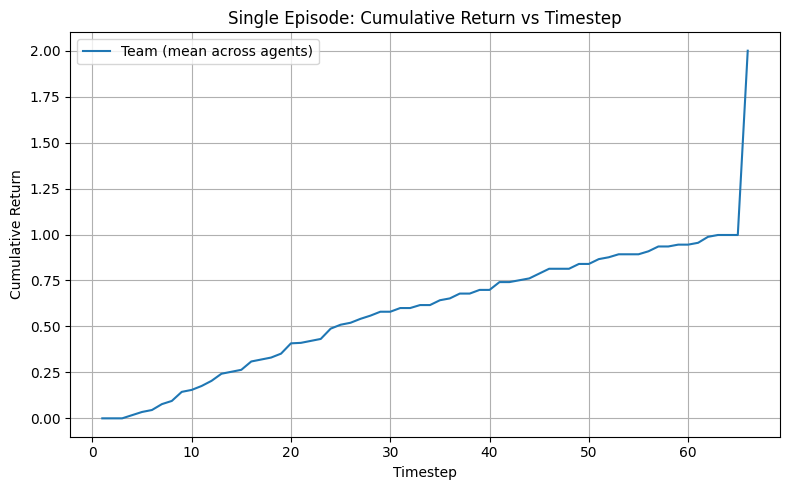

In [ ]:

evaluate_policy(params["agent"], env, config)


In [14]:
from flax.serialization import from_bytes

env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
wrapped_env = CTRolloutManager(env, batch_size=config["TEST_NUM_ENVS"])

policy_network = RNNQNetwork(
            action_dim=wrapped_env.max_action_space,
            hidden_dim=config["HIDDEN_SIZE"],
        )

# Init mixer used in qmix
mixer = MixingNetwork(
    config["MIXER_EMBEDDING_DIM"],
    config["MIXER_HYPERNET_HIDDEN_DIM"],
    config["MIXER_INIT_SCALE"],
)

# Load the seeded solution
key=jax.random.PRNGKey(config["SEED"])

init_x = (
    jnp.zeros(
        (1, 1, wrapped_env.obs_size)
    ),  # (time_step, batch_size, obs_size)
    jnp.zeros((1, 1)),  # (time_step, batch size)
)
init_hstate = ScannedRNN.initialize_carry(
    config["HIDDEN_SIZE"], 1
)  # (batch_size, hidden_dim)

dummy_params = policy_network.init(key, init_hstate, *init_x)
with open("/vol/bitbucket/eww24/Masters_project/model_params/trained_qmix_params_v2.msgpack", "rb") as f:
    loaded_agent_params = from_bytes(dummy_params, f.read())
print("Loaded agent params")

Loaded agent params


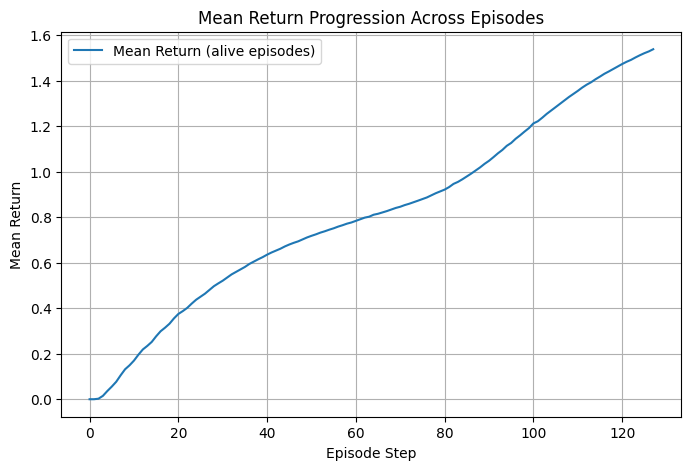

Final Win Rate across 512 envs: 0.309


{'mean_return_per_step': array([0.        , 0.        , 0.00226823, 0.01479427, 0.03606771,
        0.0554375 , 0.0767487 , 0.10529036, 0.13167839, 0.14906642,
        0.16980469, 0.19564584, 0.21879166, 0.23432162, 0.25180078,
        0.2766654 , 0.29877   , 0.31444076, 0.33180144, 0.35506445,
        0.37481543, 0.38738036, 0.4015506 , 0.42013657, 0.4372879 ,
        0.45052245, 0.46403027, 0.4806528 , 0.49672654, 0.5092387 ,
        0.52107847, 0.5348579 , 0.54881084, 0.55982065, 0.5703651 ,
        0.5815488 , 0.59467304, 0.60492694, 0.61519957, 0.6246582 ,
        0.6355176 , 0.645068  , 0.6534931 , 0.66166466, 0.67168534,
        0.6801585 , 0.6875276 , 0.69405484, 0.7028034 , 0.71119153,
        0.71833575, 0.724892  , 0.73234725, 0.73836684, 0.7452845 ,
        0.7514455 , 0.7588045 , 0.76493937, 0.77183956, 0.77702713,
        0.78403205, 0.790663  , 0.79835033, 0.80245847, 0.8110735 ,
        0.8153014 , 0.82112306, 0.8271963 , 0.8342871 , 0.8409622 ,
        0.84616065, 0.85

In [15]:
network = RNNQNetwork(
    action_dim=env.action_space(env.agents[0]).n,
    hidden_dim=config["HIDDEN_SIZE"],
)

evaluate_policy_parallel(params["agent"], config, wrapped_env, policy_network, seed=0)
#evaluate_policy_parallel(loaded_agent_params, config, wrapped_env, policy_network, seed=0)


In [ ]:
import matplotlib.animation as animation
from jaxmarl.environments.multi_agent_env import MultiAgentEnv

class Visualizer(object):
    def __init__(
        self,
        env: MultiAgentEnv,
        state_seq,
        reward_seq=None,
    ):
        self.env = env
        self.interval = 64

        # Preload data to CPU to avoid GPU-to-CPU transfers during animation
        self.state_seq = jax.device_get(state_seq)
        self.reward_seq = jax.device_get(reward_seq) if reward_seq is not None else None

        self.fig, self.ax = plt.subplots(1, 1, figsize=(6, 5))

    def animate(
        self,
        save_fname: Optional[str] = None,
        view: bool = True,
    ):
        ani = animation.FuncAnimation(
            self.fig,
            self.update,
            frames=len(self.state_seq),
            init_func=self.init,
            blit=True,  # Enables fast rendering
            interval=self.interval,
        )

        if save_fname is not None:
            ani.save(save_fname)

        if view:
            plt.show(block=True)

    def init(self):
        self.im = self.env.init_render(self.ax, self.state_seq[0])
        return [self.im]  # Required for blitting

    def update(self, frame):
        self.im = self.env.update_render(self.im, self.state_seq[frame])
        return [self.im]  # Required for blitting


class SMAXVisualizer(Visualizer):
    def __init__(
        self,
        env: MultiAgentEnv,
        state_seq,
        reward_seq=None,
    ):
        self.env = env
        self.raw_state_seq = state_seq  # GPU array until expanded
        self.reward_seq = reward_seq
        self.interval = 64
        self.have_expanded = False
        self.heuristic_enemy = isinstance(env, EnemySMAX)
        self.fig, self.ax = plt.subplots(1, 1, figsize=(6, 5))

    def expand_state_seq(self):
        """Expands the state sequence for higher frame resolution."""
        expanded = self.env.expand_state_seq(self.raw_state_seq)
        self.state_seq = jax.device_get(expanded)  # Preload to CPU
        self.have_expanded = True

    def animate(self, save_fname: Optional[str] = None, view: bool = True):
        if not self.have_expanded:
            self.expand_state_seq()
        return super().animate(save_fname, view)

    def init(self):
        self.im = self.env.init_render(self.ax, self.state_seq[0], 0, 0)
        return [self.im]  # Required for blitting

    def update(self, frame):
        self.im = self.env.update_render(
            self.im,
            self.state_seq[frame],
            frame % self.env.world_steps_per_env_step,
            frame // self.env.world_steps_per_env_step,
        )
        return [self.im]  # Required for blitting


def visualize_recurrent_policy(trained_params, env, config):
    rng = jax.random.PRNGKey(config["SEED"])
    rng, reset_rng = jax.random.split(rng)
    #wrapped_env = CTRolloutManager(env, batch_size=1)


    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=config["HIDDEN_SIZE"],
    )
    
    # Reset environment
    obs, env_state = env.reset(reset_rng)

    dones = {agent: jnp.array(False) for agent in env.agents}
    hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), 1
    )
    
    # Collect all environment states
    returns = {agent: 0.0 for agent in env.agents}
    state_seq = []
    max_steps = config["NUM_STEPS"]

    for step in range(max_steps):
        # Compute Q-values
        # Prepare inputs for network
        obs = preprocess_obs_with_id(obs, env)
        _obs = batchify(obs)         # (num_agents, obs_dim)
        _obs = _obs[:, None, :]                      # (num_agents, 1, obs_dim)
        _dones = jnp.stack([jnp.array([dones[agent]]) for agent in env.agents])  # shape (num_agents, 1)
        _dones = jnp.expand_dims(_dones, axis=-1)  # from (3, 1) to (3, 1, 1)

        #print("_obs.shape:", _obs.shape)
        #print("_dones.shape:", _dones.shape)
        #print("hstate.shape:", hstate.shape)

        def apply_fn(h, o, d):
            return network.apply(trained_params, h, o, d)

        hstate, q_vals = jax.vmap(apply_fn, in_axes=(0, 0, 0))(
            hstate,
            _obs,
            _dones,
        )
        #print("hstate.shape:", hstate.shape)

        q_vals = q_vals.squeeze(axis=1)  # (num_agents, num_envs, num_actions) remove the time dim
        #print("q_vals.shape", q_vals.shape)
        
        actions = {}
        #avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
        avail_actions = env.get_avail_actions(env_state.env_state)

        for i, agent in enumerate(env.agents):
            avail_agent = avail_actions[agent][None, None, :]  # shape (1, 1, n_actions)
            #print("avail_agent.shape", avail_agent.shape)
            
            unavail_actions = 1 - avail_agent  # shape (1, 1, n_actions)
            
            # Select Q-values for this agent only
            q_agent = q_vals[i][None, None, :]  # shape (1, 1, n_actions)
            q_masked = q_agent - (unavail_actions * 1e10)

            action = jnp.argmax(q_masked, axis=-1)  # shape (1, 1)
            action = action.squeeze()               # scalar
            #print("action.shape", action.shape)

            # Wrap in array with batch dim
            actions[agent] = int(action)    # shape (1,)
        
        rng, rng_s = jax.random.split(rng)
        state_seq.append((rng_s, env_state.env_state, actions))

        # Step environment
        obs, env_state, rewards, dones, infos = env.step(rng_s, env_state, actions)
        returns = {a: returns[a] + rewards[a] for a in env.agents}
        
        if dones["__all__"]:
            break

    # Visualization
    print("Returns:", returns)

    viz = SMAXVisualizer(env, state_seq)
    viz.animate(view=False, save_fname="evaluation.gif")

Returns: {'ally_0': Array(2., dtype=float32), 'ally_1': Array(2., dtype=float32), 'ally_2': Array(2., dtype=float32), 'ally_3': Array(2., dtype=float32), 'ally_4': Array(2., dtype=float32)}


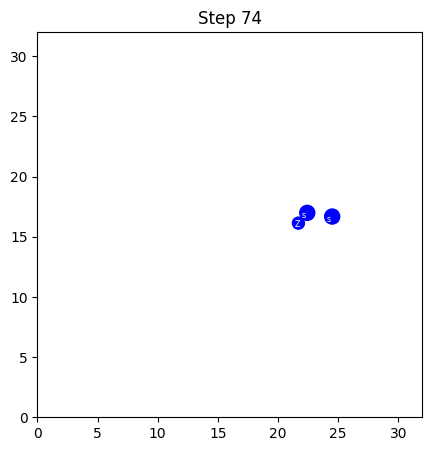

In [17]:
visualize_recurrent_policy(params["agent"], env, config)

In [18]:
from PIL import Image
import os

# --- Setup evaluation folder structure ---
eval_dir = "evaluation"
os.makedirs(eval_dir, exist_ok=True)

# Build a descriptive name dynamically
name = f"descriptor_{descriptor[0]:.3f}_{descriptor[1]:.3f}_index_{index}"

# Folder to store PNG frames
frames_dir = os.path.join(eval_dir, name)
os.makedirs(frames_dir, exist_ok=True)

# Original GIF name created by the visualizer
original_gif = "evaluation.gif"  # or whatever fixed name the Visualizer uses

# Target GIF path with the new name
gif_path = os.path.join(eval_dir, name + ".gif")

# Rename/move the GIF to your preferred name
if os.path.exists(original_gif):
    os.replace(original_gif, gif_path)
else:
    raise FileNotFoundError(f"{original_gif} not found. Make sure the GIF was generated first.")

# --- Extract only the LAST PNG per environment step ---
gif = Image.open(gif_path)
frame_idx = 0
step_idx = 0

while True:
    # Save only the last subframe of each environment step
    if (frame_idx + 1) % env.world_steps_per_env_step == 0:
        frame_path = os.path.join(frames_dir, f"step_{step_idx:05d}.png")
        gif.save(frame_path, "PNG")
        step_idx += 1

    frame_idx += 1
    try:
        gif.seek(frame_idx)
    except EOFError:
        break

print(f"Saved GIF to {gif_path}")
print(f"Saved {step_idx} PNG step-frames into {frames_dir}")

Saved GIF to evaluation/descriptor_0.446_0.405_index_44.gif
Saved 74 PNG step-frames into evaluation/descriptor_0.446_0.405_index_44
